In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Set plot style
plt.style.use('ggplot')
sns.set_theme(font_scale=1.2)

# For reproducibility
np.random.seed(42)

In [2]:
# Load the project dataset
from prep import preprocess_data

train_df = pd.read_csv('./apache/train_labeled.csv')
test_df = pd.read_csv('./apache/test_labeled.csv')

train_df = preprocess_data(train_df, compact=True)
test_df = preprocess_data(test_df, compact=True)

# check if the columns are the same
if set(train_df.columns) != set(test_df.columns):
    print("Warning: Train and test datasets have different columns.")
    # Print the differences
    train_columns = set(train_df.columns)
    test_columns = set(test_df.columns)
    # get the columns that are in train but not in test
    train_only = train_columns - test_columns
    # get the columns that are in test but not in train
    test_only = test_columns - train_columns
    if train_only:
        print(f"Columns in train but not in test: {train_only}")
    if test_only:
        print(f"Columns in test but not in train: {test_only}")

In [3]:
# Encode 'project_category' using data from train_df
oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_encoded = oe.fit_transform(train_df[['project_category']])
test_encoded = oe.transform(test_df[['project_category']])
# Create DataFrames for the encoded categories
train_encoded_df = pd.DataFrame(train_encoded, columns=oe.get_feature_names_out(['project_category']))
test_encoded_df = pd.DataFrame(test_encoded, columns=oe.get_feature_names_out(['project_category']))
# Concatenate the encoded DataFrames with the original DataFrames
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [4]:
# useful columns derived from feature engineering
top_risk_predictors = pd.read_csv('./apache/top_risk_predictors.csv')
schedule_features = top_risk_predictors['Schedule Risk Predictors'].tolist()
quality_features = top_risk_predictors['Quality Risk Predictors'].tolist()

# Filter the DataFrame to keep only the top predictors (plus 'project_category' and the target variable)
schedule_train_df = train_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_train_df = train_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

schedule_test_df = test_df[schedule_features + oe.get_feature_names_out(['project_category']).tolist() + ['schedule_risk']]
quality_test_df = test_df[quality_features + oe.get_feature_names_out(['project_category']).tolist() + ['quality_risk']]

In [5]:
target = 'schedule_risk'
# target = 'quality_risk'

if target == 'schedule_risk':
    train_df = schedule_train_df
    test_df = schedule_test_df
    features = schedule_features
elif target == 'quality_risk':
    train_df = quality_train_df
    test_df = quality_test_df
    features = quality_features

In [6]:
# Prepare data for modeling
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

# Feature scaling (optional but recommended for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize Decision Tree Classifier
dt_classifier = tree.DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=dt_classifier, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from Grid Search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}" )

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.8923


Test Accuracy: 0.8790

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        93
           1       0.74      0.81      0.77        31

    accuracy                           0.88       124
   macro avg       0.83      0.85      0.84       124
weighted avg       0.88      0.88      0.88       124



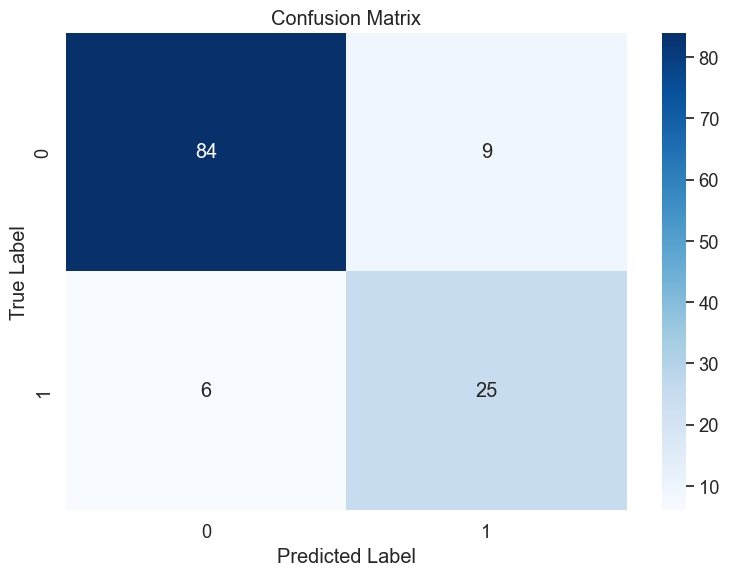

In [8]:
# Model Evaluation

# Make predictions on the test set
# Use X_test_scaled instead of X_test to match what the model was trained on
y_pred = best_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

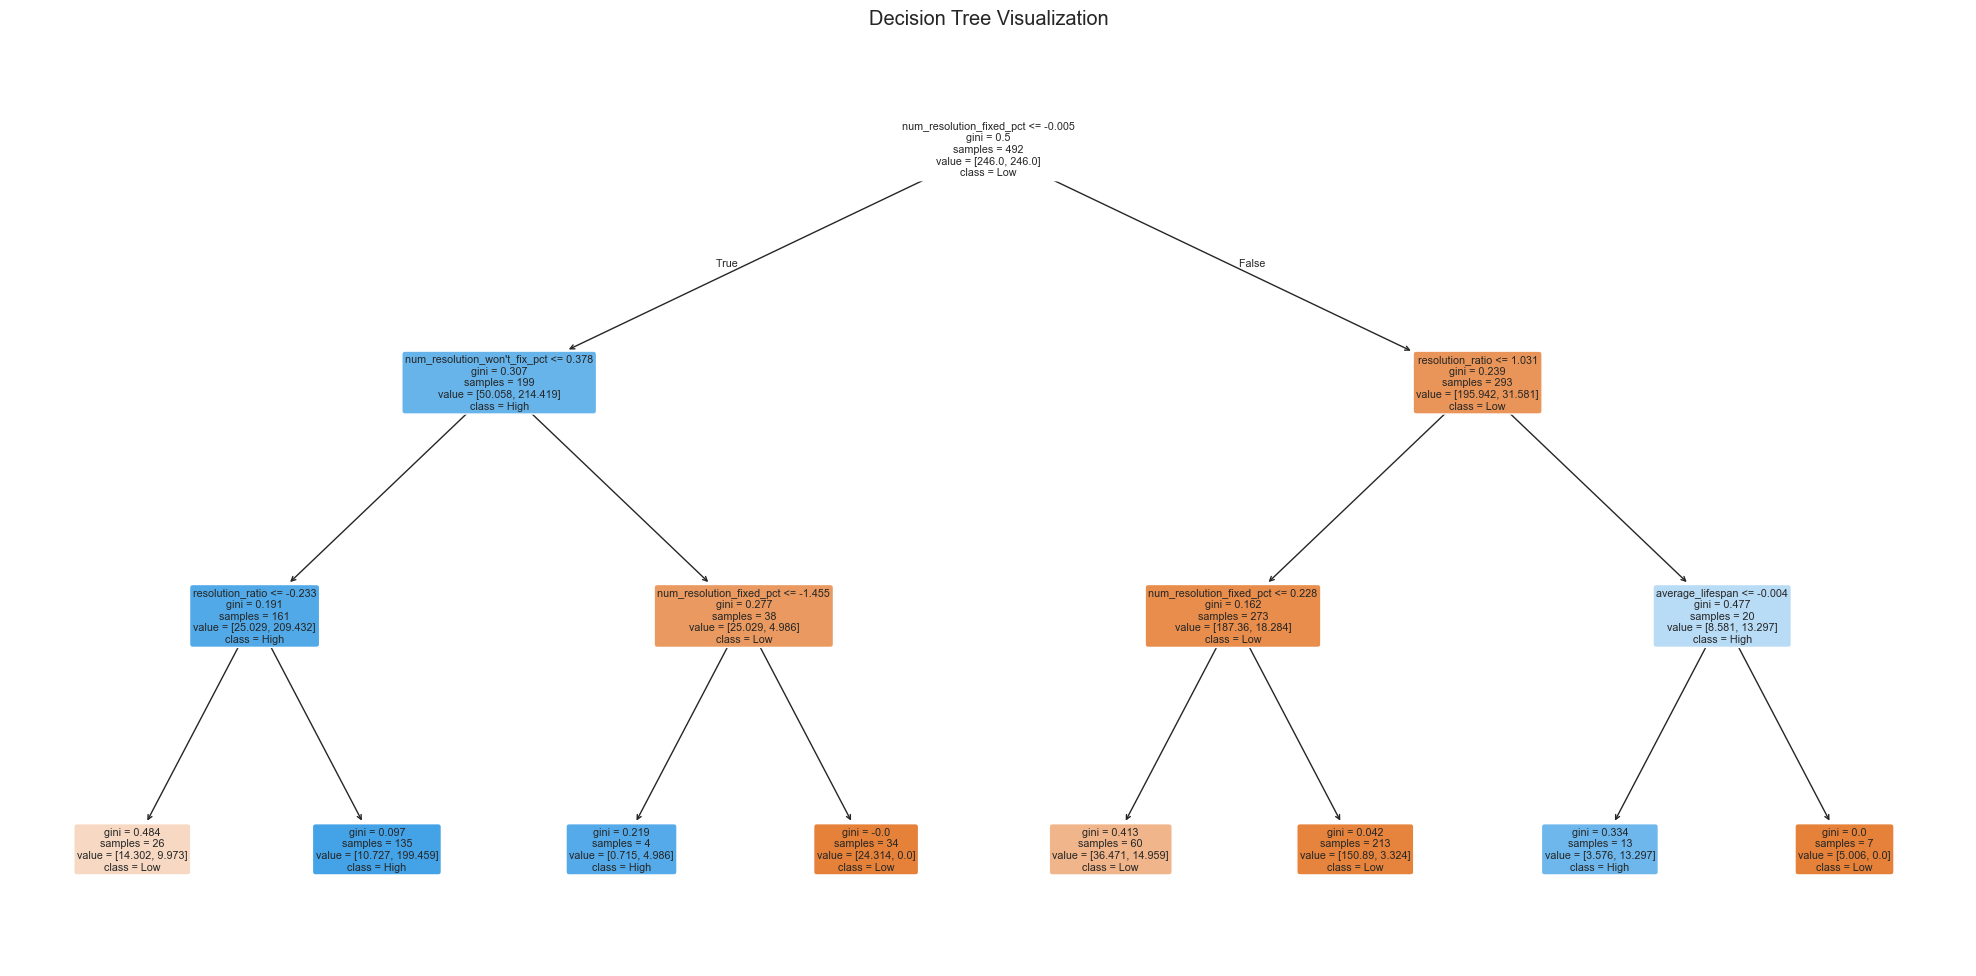

In [9]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
tree.plot_tree(best_model, feature_names=X_train.columns, class_names=['Low', 'High'], filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.tight_layout()

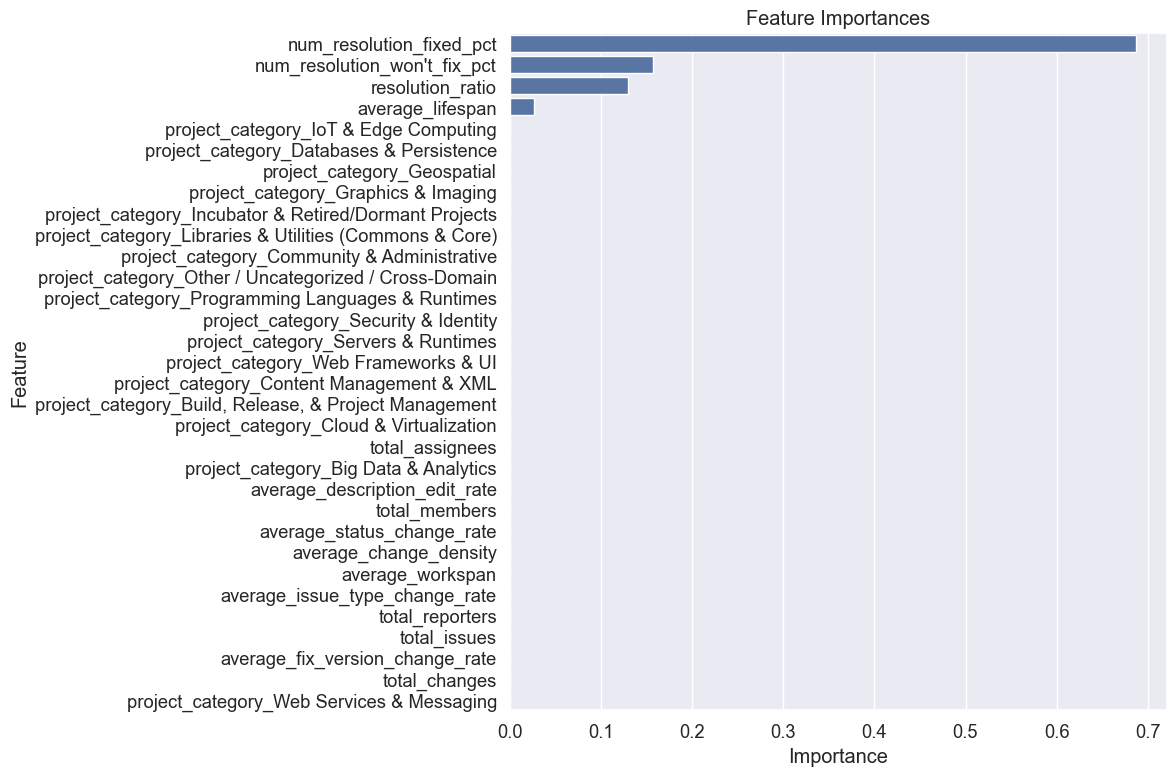

In [10]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

max_depth=2 - Train Accuracy: 0.8760, Test Accuracy: 0.8387
max_depth=3 - Train Accuracy: 0.9228, Test Accuracy: 0.8790
max_depth=4 - Train Accuracy: 0.9329, Test Accuracy: 0.8871
max_depth=5 - Train Accuracy: 0.9695, Test Accuracy: 0.9032
max_depth=None - Train Accuracy: 1.0000, Test Accuracy: 0.8871


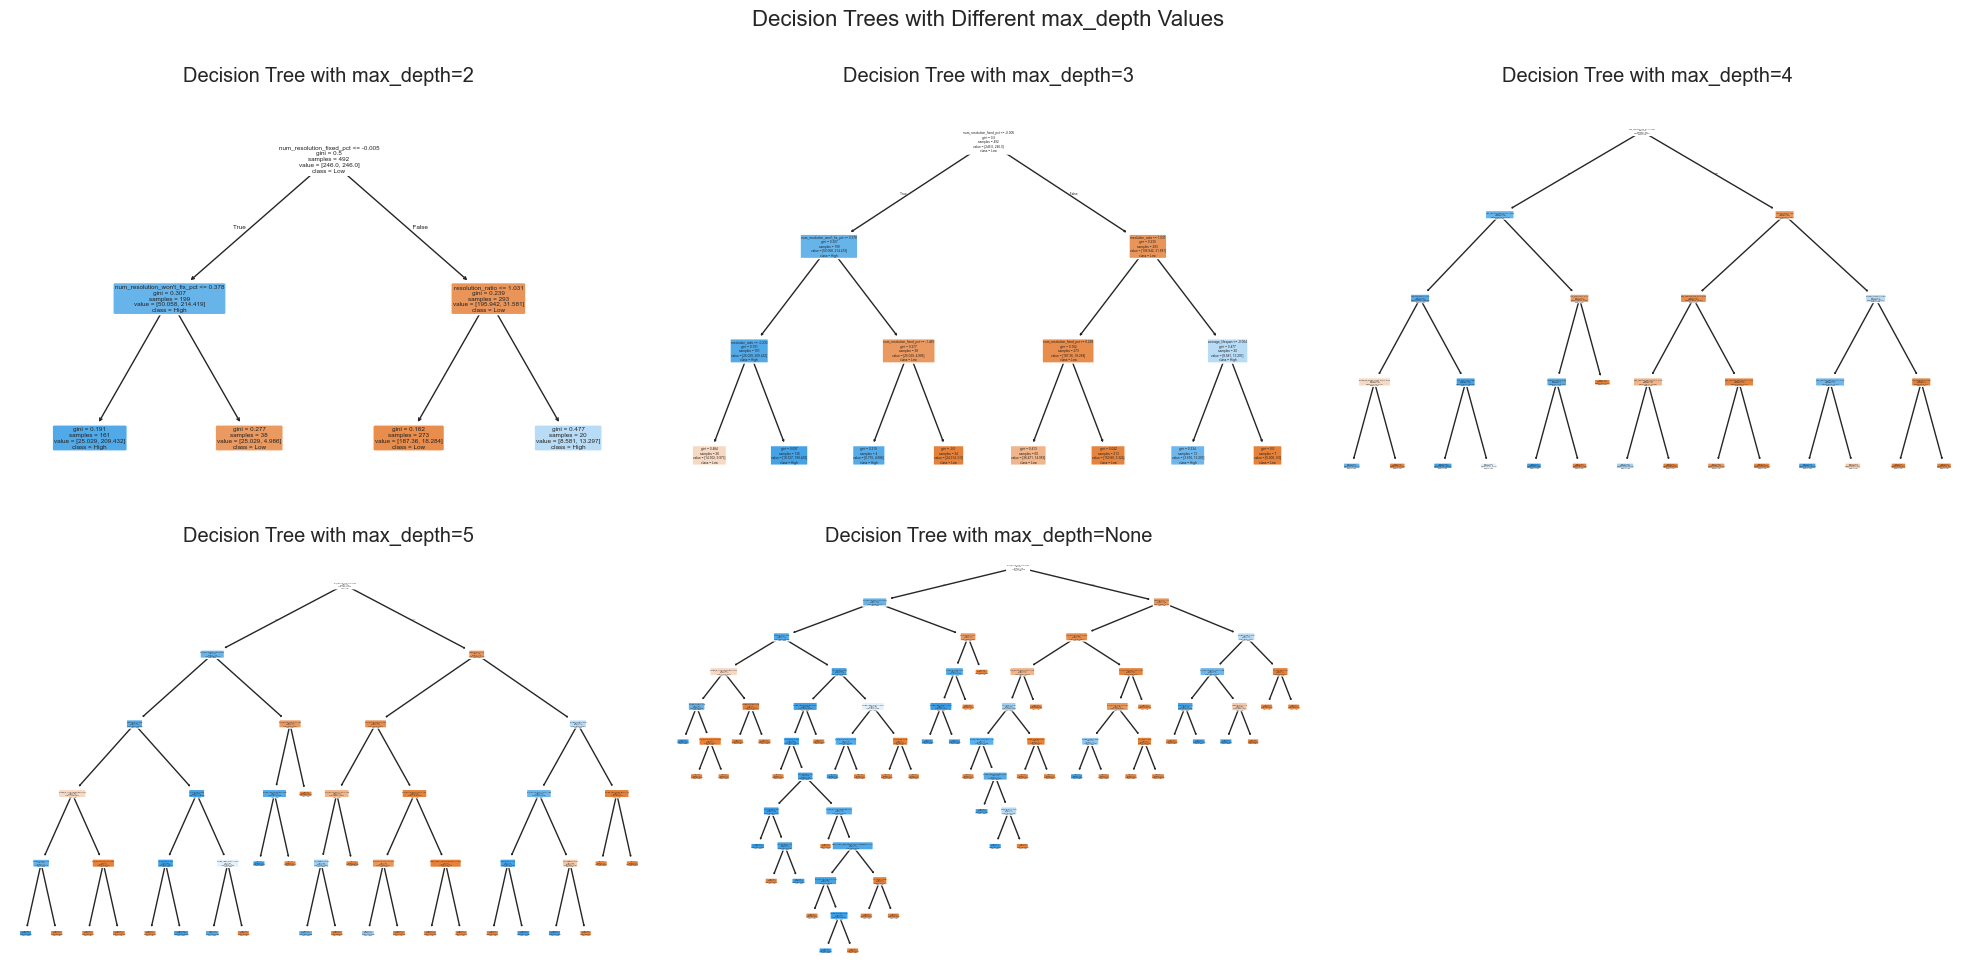

In [11]:
# Compare decision trees with different max_depth values
max_depths = [2, 3, 4, 5, None]

plt.figure(figsize=(20, 10))

for i, depth in enumerate(max_depths):
    dt_classifier = tree.DecisionTreeClassifier(max_depth=depth, random_state=42, class_weight='balanced')
    dt_classifier.fit(X_train_scaled, y_train)
    
    plt.subplot(2, 3, i + 1)
    tree.plot_tree(dt_classifier, feature_names=X_train.columns, class_names=['Low', 'High'], filled=True, rounded=True)
    plt.title(f'Decision Tree with max_depth={depth}')

    # Calculate and display accuracy for each depth
    train_acc = dt_classifier.score(X_train_scaled, y_train)
    test_acc = dt_classifier.score(X_test_scaled, y_test)
    print(f"max_depth={depth} - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Decision Trees with Different max_depth Values', fontsize=16)
plt.show()

In [12]:
# Get indices of the top 5 features
np.argsort(feature_importances)[-5:]

array([30, 11, 14,  3,  0], dtype=int64)

In [13]:
feature_importances

array([0.68661786, 0.        , 0.        , 0.15694056, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02674765, 0.        , 0.        , 0.12969393,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [14]:
features

['num_resolution_fixed_pct',
 'total_assignees',
 'total_changes',
 "num_resolution_won't_fix_pct",
 'average_fix_version_change_rate',
 'total_issues',
 'total_reporters',
 'average_issue_type_change_rate',
 'average_workspan',
 'average_change_density',
 'average_status_change_rate',
 'average_lifespan',
 'total_members',
 'average_description_edit_rate',
 'resolution_ratio']

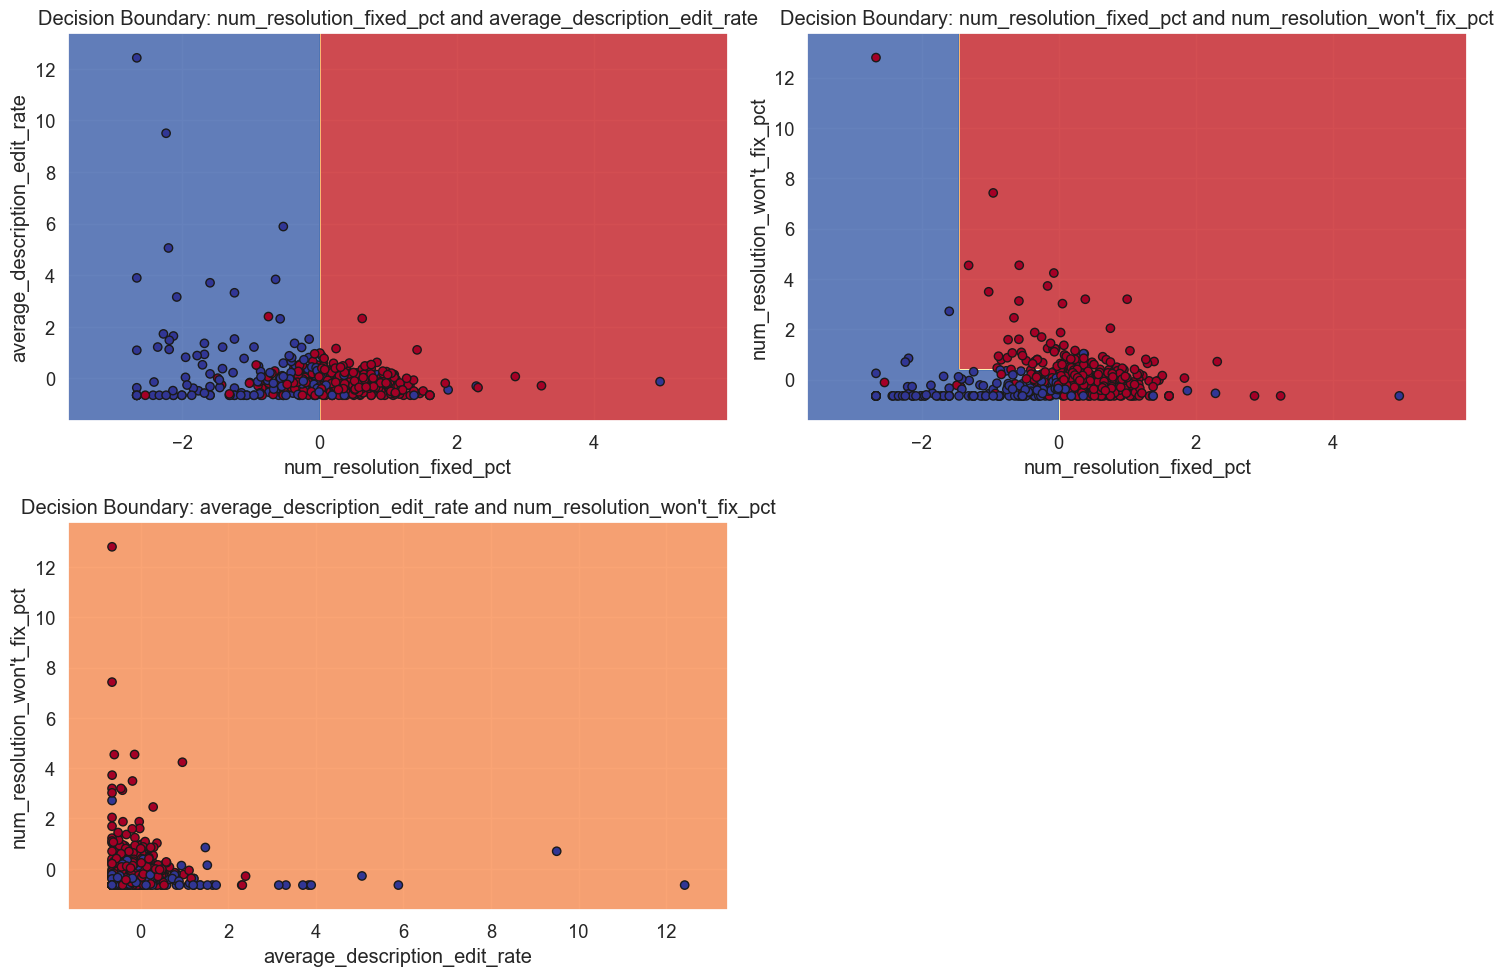

In [15]:
# Decision Boundary Visualization (for 2 features)

def plot_decision_boundary(model, X, y, feature_indices):
    # Extract the two features for visualization
    X_subset = X[:, feature_indices]
    
    # Create a mesh grid
    h = 0.02  # mesh step size
    x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
    y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create features for prediction
    Z_input = np.c_[xx.ravel(), yy.ravel()]
    
    # For models trained on all features, we need to provide defaults for the other features
    if X.shape[1] > 2:
        # Use the mean value for other features
        defaults = np.mean(X, axis=0)
        grid_points = np.tile(defaults, (Z_input.shape[0], 1))
        for idx, feat_idx in enumerate(feature_indices):
            grid_points[:, feat_idx] = Z_input[:, idx]
        Z = model.predict(grid_points)
    else:
        Z = model.predict(Z_input)
    
    # Reshape the prediction to match the mesh grid
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    
    # Plot the training points
    plt.scatter(X_subset[:, 0], X_subset[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)
    
    # Labels and title
    plt.xlabel(features[feature_indices[0]])
    plt.ylabel(features[feature_indices[1]])
    plt.title(f'Decision Boundary: {features[feature_indices[0]]} and {features[feature_indices[1]]}')

# Plot decision boundaries for different feature combinations
plt.figure(figsize=(15, 10))

# Feature combinations to visualize
feature_combinations = [
    # top 3 features
    (0, 13),
    (0, 3),
    (13, 3)
]

for i, (f1, f2) in enumerate(feature_combinations):
    plt.subplot(2, 2, i+1)
    plot_decision_boundary(best_model, X_train_scaled, y_train, [f1, f2])

plt.tight_layout()
plt.show()

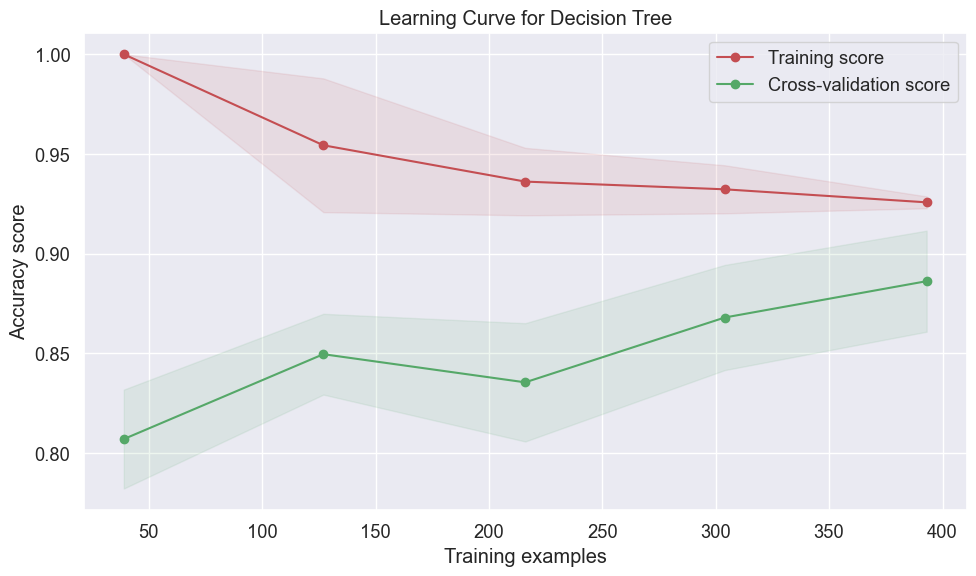

In [16]:
# Learning Curve Analysis
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    # Calculate mean and std for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Calculate mean and std for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy score")
    plt.title("Learning Curve for Decision Tree")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot learning curve
plot_learning_curve(best_model, X_train_scaled, y_train, cv=5, n_jobs=-1)

In [17]:
# Save the model for future use
import joblib

# Create a directory for models if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the best model
model_filename = f'models/{target}_decision_tree_model.joblib'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

# Save the scaler for future use
scaler_filename = f'models/{target}_decision_tree_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")

# Example of how to load the model
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
print(f"Loaded model accuracy on test set: {loaded_model.score(X_test_scaled, y_test):.4f}")

Model saved to models/schedule_risk_decision_tree_model.joblib
Scaler saved to models/schedule_risk_decision_tree_scaler.joblib
Model loaded from models/schedule_risk_decision_tree_model.joblib
Loaded model accuracy on test set: 0.8790
